# Task 3

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
customer_data = pd.merge(customers, transactions, on='CustomerID')

In [4]:
customer_data.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64


In [5]:
#Total spending per customer
customer_data['TotalSpending'] = customer_data['Quantity'] * customer_data['Price']
total_spending = customer_data.groupby('CustomerID')['TotalSpending'].sum().reset_index()
total_spending

,CustomerID,TotalSpending
0,C0001,3354.52
1,C0002,1862.74
2,C0003,2725.38
3,C0004,5354.88
4,C0005,2034.24
...,...,...
194,C0196,4982.88
195,C0197,1928.65
196,C0198,931.83
197,C0199,1979.28


In [17]:
#RFM features
customer_data['TransactionDate'] = pd.to_datetime(customer_data['TransactionDate'])
recent_date = customer_data['TransactionDate'].max()
customer_data['Recency'] = (recent_date - customer_data['TransactionDate']).dt.days
rfm = customer_data.groupby('CustomerID').agg({'Recency': 'min', 'TransactionID': 'count', 'TotalSpending': 'sum'})
rfm.rename(columns={'TransactionID': 'Frequency', 'TotalSpending': 'Monetary'}, inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
C0001,55,5,3354.52
C0002,25,4,1862.74
C0003,125,4,2725.38
C0004,4,8,5354.88
C0005,54,3,2034.24


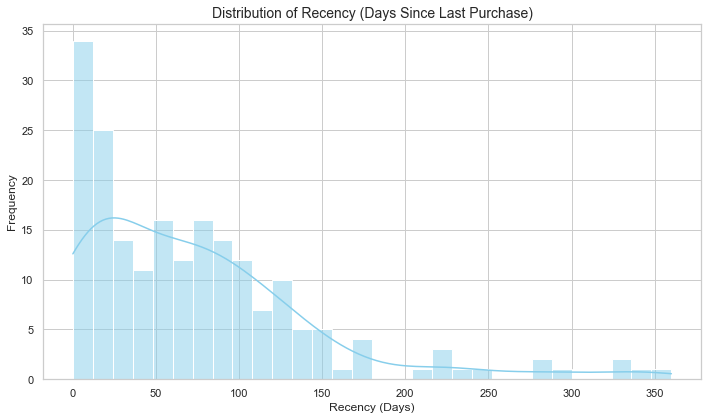

In [18]:
sns.set(style="whitegrid")

#Recency  
plt.figure(figsize=(10, 6))
sns.histplot(rfm['Recency'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Recency (Days Since Last Purchase)', fontsize=14)
plt.xlabel('Recency (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()



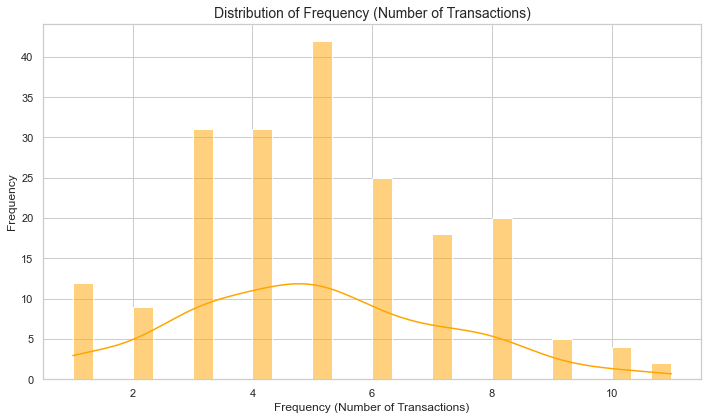

In [19]:
#Frequency 
plt.figure(figsize=(10, 6))
sns.histplot(rfm['Frequency'], bins=30, kde=True, color='orange')
plt.title('Distribution of Frequency (Number of Transactions)', fontsize=14)
plt.xlabel('Frequency (Number of Transactions)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()



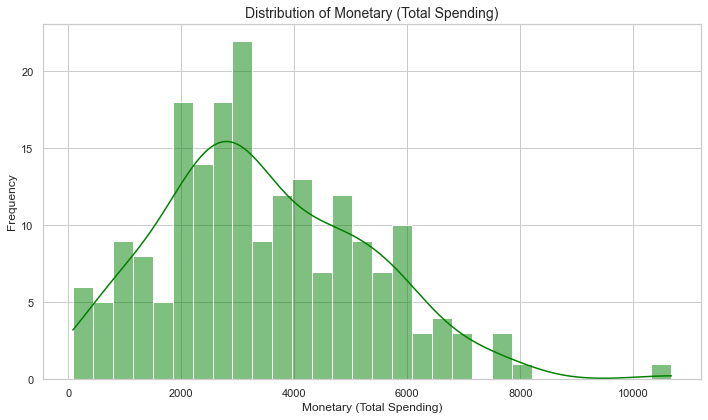

In [20]:
#Monetary 
plt.figure(figsize=(10, 6))
sns.histplot(rfm['Monetary'], bins=30, kde=True, color='green')
plt.title('Distribution of Monetary (Total Spending)', fontsize=14)
plt.xlabel('Monetary (Total Spending)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


In [16]:
#Merge features
customer_profiles = pd.merge(customers, rfm, on='CustomerID')
customer_profiles = customer_profiles.set_index('CustomerID')
customer_profiles.head()


,CustomerName,Region,SignupDate,Recency,Frequency,Monetary
CustomerID,,,,,,
C0001,Lawrence Carroll,South America,2022-07-10,55,5,3354.52
C0002,Elizabeth Lutz,Asia,2022-02-13,25,4,1862.74
C0003,Michael Rivera,South America,2024-03-07,125,4,2725.38
C0004,Kathleen Rodriguez,South America,2022-10-09,4,8,5354.88
C0005,Laura Weber,Asia,2022-08-15,54,3,2034.24


In [34]:
customer_encoder = LabelEncoder()
customer_profiles['RegionEncoded'] = customer_encoder.fit_transform(customer_profiles['Region'])
customer_profiles = customer_profiles.dropna(subset=['Recency', 'Frequency', 'Cluster'])
customer_profiles.head()

,CustomerName,Region,SignupDate,Recency,Frequency,Monetary,RegionEncoded,Cluster
CustomerID,,,,,,,,
C0001,Lawrence Carroll,South America,2022-07-10,55,5,3354.52,3,1
C0002,Elizabeth Lutz,Asia,2022-02-13,25,4,1862.74,0,1
C0003,Michael Rivera,South America,2024-03-07,125,4,2725.38,3,1
C0004,Kathleen Rodriguez,South America,2022-10-09,4,8,5354.88,3,0
C0005,Laura Weber,Asia,2022-08-15,54,3,2034.24,0,1


In [24]:
features = ['RegionEncoded', 'Recency', 'Frequency', 'Monetary']
X = customer_profiles[features]
X.head()

,RegionEncoded,Recency,Frequency,Monetary
CustomerID,,,,
C0001,3,55,5,3354.52
C0002,0,25,4,1862.74
C0003,3,125,4,2725.38
C0004,3,4,8,5354.88
C0005,0,54,3,2034.24


In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
#K-Means clustering
n_clusters = 3  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
customer_profiles['Cluster'] = kmeans.fit_predict(X_scaled)

In [27]:
db_index = davies_bouldin_score(X_scaled, customer_profiles['Cluster'])
silhouette = silhouette_score(X_scaled, customer_profiles['Cluster'])
calinski_harabasz = calinski_harabasz_score(X_scaled, customer_profiles['Cluster'])

print(f"DB Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

DB Index: 1.240165936934891
Silhouette Score: 0.2733638713438174
Calinski-Harabasz Index: 83.70696981899586


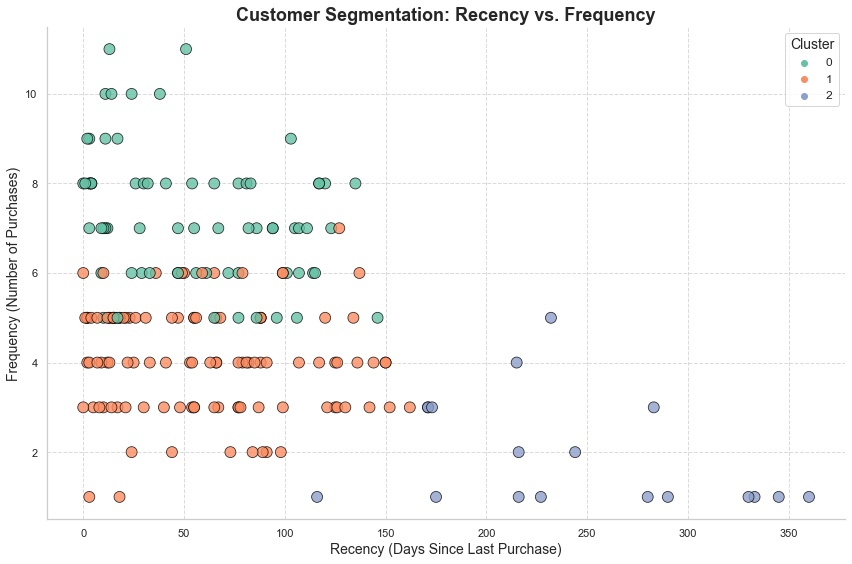

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

sns.scatterplot(
    x='Recency',
    y='Frequency',
    hue='Cluster',
    data=customer_profiles,
    palette='Set2',
    s=120,
    alpha=0.8,
    edgecolor='black',
    linewidth=0.8,
)

plt.title('Customer Segmentation: Recency vs. Frequency', fontsize=18, fontweight='bold')
plt.xlabel('Recency (Days Since Last Purchase)', fontsize=14)
plt.ylabel('Frequency (Number of Purchases)', fontsize=14)

plt.legend(title='Cluster', title_fontsize=14, fontsize=12, loc='upper right')

sns.despine()
plt.grid(True, linestyle='--', alpha=0.7, axis='both')

plt.tight_layout()

plt.show()


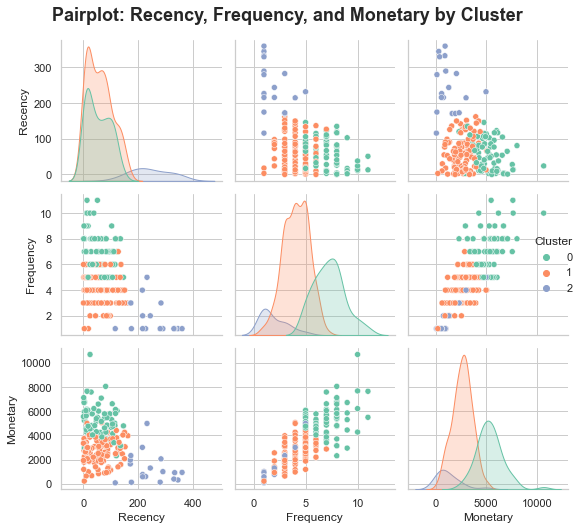

In [41]:
# Pairplot to show the relationships between Recency, Frequency, and Monetary
sns.pairplot(customer_profiles[['Recency', 'Frequency', 'Monetary', 'Cluster']], hue='Cluster', palette='Set2')

plt.suptitle('Pairplot: Recency, Frequency, and Monetary by Cluster', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()


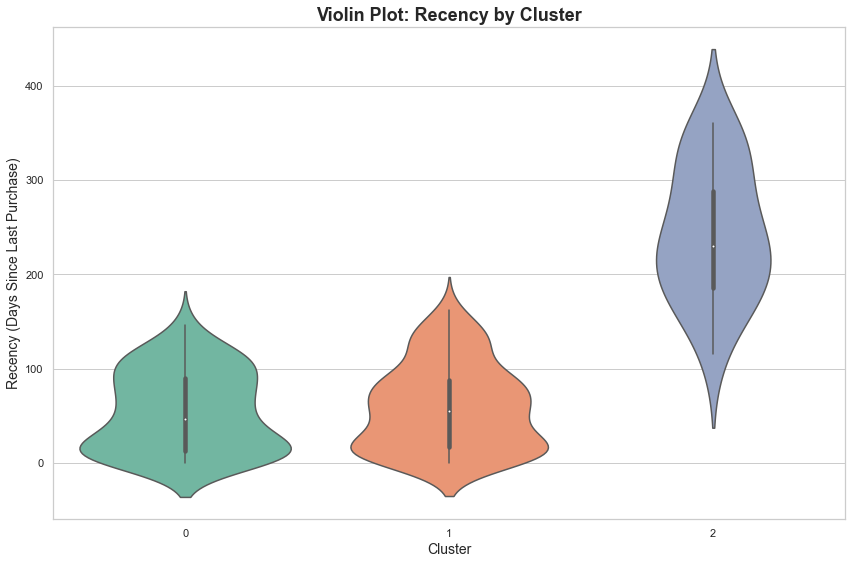

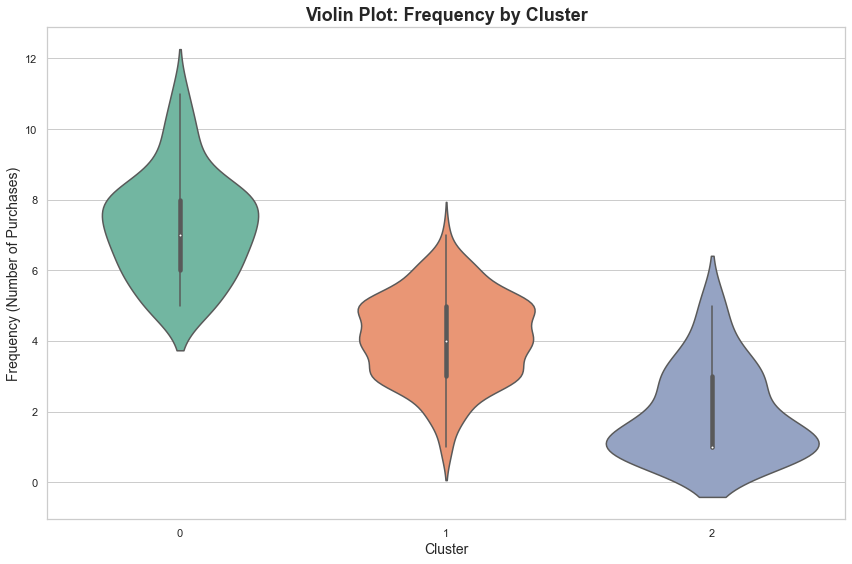

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Violin plot for Recency by Cluster
plt.figure(figsize=(12, 8))
sns.violinplot(x='Cluster', y='Recency', data=customer_profiles, palette='Set2')

plt.title('Violin Plot: Recency by Cluster', fontsize=18, fontweight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Recency (Days Since Last Purchase)', fontsize=14)
plt.tight_layout()
plt.show()

# Violin plot for Frequency by Cluster
plt.figure(figsize=(12, 8))
sns.violinplot(x='Cluster', y='Frequency', data=customer_profiles, palette='Set2')

plt.title('Violin Plot: Frequency by Cluster', fontsize=18, fontweight='bold')
plt.xlabel('Cluster', fontsize=14)
plt.ylabel('Frequency (Number of Purchases)', fontsize=14)
plt.tight_layout()
plt.show()


Report on Clustering Results:

We performed customer segmentation using clustering techniques on customer data, specifically focusing on three key features: Recency, Frequency, and Monetary. After applying the K-Means algorithm, we arrived at 3 distinct clusters. These clusters represent groups of customers with similar purchasing behaviors, allowing for targeted marketing strategies or tailored business approaches.

The Davies-Bouldin Index is a metric used to evaluate the quality of clustering by considering the dispersion within each cluster and the separation between clusters. Lower DB Index values indicate better clustering performance. In our case, the DB Index value is computed as follows:

DB Index:1.240165936934891

Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters. A score closer to 1 indicates that the clusters are well-separated and distinct.

Silhouette Score:0.2733638713438174

The Calinski-Harabasz Index (Variance Ratio Criterion) is another important clustering evaluation metric. It measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion. A higher Calinski-Harabasz index indicates better-defined and well-separated clusters.

Calinski-Harabasz Index: 83.71
